In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import network
from numba import jit, njit, double, int8, int64
from numba_progress import ProgressBar

# Aufgabe 6 
> Zielsetzung:
- Einfluss von Wechselwirkungsenergien untersuchen: Graduelles Abkühlen für $J_{ij} = -3 = \epsilon$ analog zu ex 5,
- Berechnung bzw. Auftragung der Spezifischen Wärme $C(T) = \epsilon^2 \frac{\langle n^2 \rangle - \langle n \rangle ^2}{NT^2}$,
- Analytischer Ausdruck der inneren Energie $E(\langle n \rangle)$,
- Dauer für metastabilen Zustand bei T = 1,
- Dauer für metastabilen Zustand bei T = 1 für zufälliges Vorzeichen $J_{ij} = \pm 3$. 

> Durchführung der Monte-Carlo-Simulation mit annealing für Temperaturabhängigkeiten von Energie, Größe und spezifischer Wärme des Proteins bei $J_{ij} = -3$:

In [3]:
@njit(nogil=True)
def monte_carlo_temperature(protein, temperature_0, temperature_1, number_of_steps, number_of_repeats, progress_proxy):
    
    temperature = np.linspace(temperature_0, temperature_1, number_of_steps)
    simulation = np.zeros(shape=(number_of_steps, 3), dtype=double)
  
    for step in range(number_of_steps):
        energy_mean = 0
        size_mean = 0
        n = 0
        n_squared = 0
        for temperature_step in range(number_of_repeats):
            
            protein.random_fold_step(temperature[step])
            energy_mean += protein.calc_energy()
            size_mean += protein.calc_size()
            n += protein.calc_next_neighbors()
            n_squared += n ** 2
            progress_proxy.update(1)
        
        n /= number_of_repeats
        n_squared /= number_of_repeats
        
        energy_mean /= number_of_repeats
        size_mean /= number_of_repeats
        
        simulation[step][0] = energy_mean
        simulation[step][1] = size_mean
        simulation[step][2] = 0.3 * (n_squared - n ** 2) / (temperature[step] ** 2)
        
    return simulation

steps = 100
repeats = 100000

T_0 = 10
T_1 = 1

num_of_proteins = 2
num_iterations = num_of_proteins * (steps * repeats - repeats)

p1 = network.create_protein(interaction_type='const')
p2 = network.Protein(np.copy(p1.chain), np.copy(p1.J))

with ProgressBar(total=num_iterations) as progress:
    arr_T_1 = monte_carlo_temperature(p1, T_0, T_1, steps, repeats, progress)
    arr_T_2 = monte_carlo_temperature(p2, T_0, T_1, steps, repeats, progress)

energy_1 = arr_T_1[:, 0]
size_1 = arr_T_1[:, 1]
capacity_1 = arr_T_1[:, 2]
energy_2 = arr_T_2[:, 0]
size_2 = arr_T_2[:, 1]
capacity_2 = arr_T_2[:, 2]

  0%|          | 0/1980000 [00:00<?, ?it/s]

>Auftragung der Energien:

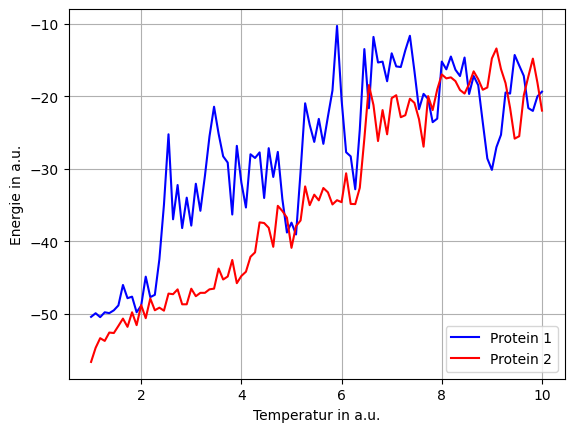

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Energie in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), energy_1, color='blue', label='Protein 1')
ax.plot(np.linspace(T_0, T_1, int(steps)), energy_2, color='red', label='Protein 2')
plt.legend(loc='lower right')

>Auftragung der Endenabstände:

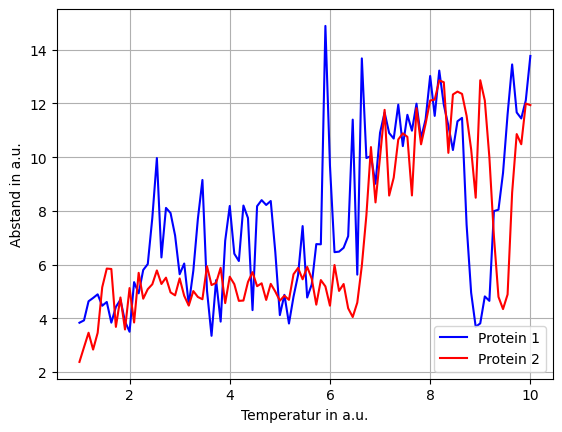

In [5]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Abstand in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), size_1, color='blue', label='Protein 1')
ax.plot(np.linspace(T_0, T_1, int(steps)), size_2, color='red', label='Protein 2')
plt.legend(loc='lower right')

> Auftragung der Wärmekapazitäten:

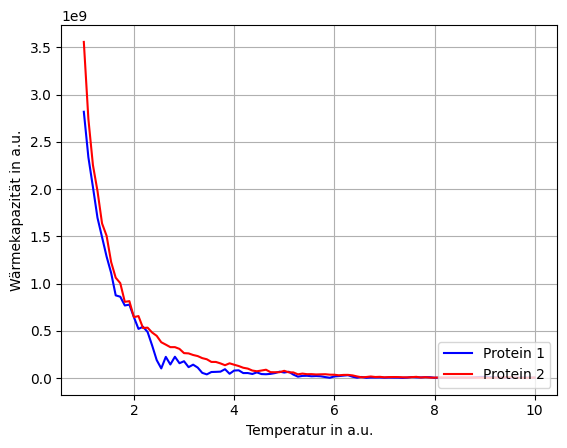

In [6]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Wärmekapazität in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), capacity_1, color='blue', label='Protein 1')
ax.plot(np.linspace(T_0, T_1, int(steps)), capacity_2, color='red', label='Protein 2')
plt.legend(loc='lower right')

> Zeichnen der gefalteten Tertiärstrukturen:

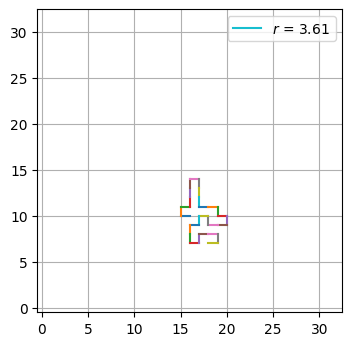

In [7]:
network.plot_protein(p1)

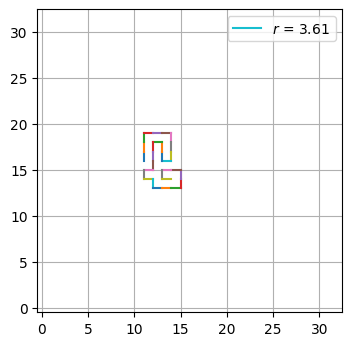

In [8]:
network.plot_protein(p2)

>Untersuche nun die Zeit, um bei $T=1$ einen metastabilen Zustand zu erreichen. Zunächst mit $\epsilon = -3$:

In [2]:
@njit(nogil=True)
def monte_carlo_find_first_stable(protein, temp, number_of_steps, progress_proxy):
    
    simulation = np.zeros(int(number_of_steps), dtype=double)
    min_energy = 0
    threshold = 3
    last_peak = False
    searching = True
    
    stable_state_start = 0
    stable_state_stop = 0
    
    for step in range(number_of_steps):
        
        current_energy = protein.calc_energy()
        simulation[step] = current_energy
        if current_energy <= min_energy - threshold:
            if last_peak and searching:
                stable_state_stop = step
                searching = False

                
            if searching:
                stable_state_start = step
                
            min_energy = current_energy
            last_peak = False
            
        if current_energy > min_energy + threshold:
            last_peak = True
            
        protein.random_fold_step(temp)
        progress_proxy.update(1)

       # if peak_step != 0 and step > peak_step + 50:
        #    break
        
    return simulation, stable_state_start, stable_state_stop


In [5]:
steps = 1e6
temperature = 1

p = network.create_protein(interaction_type='const')

with ProgressBar(total=steps) as progress:
    arr, start, stop = monte_carlo_find_first_stable(p, temperature, steps, progress)

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

> Plotte den ersten Metastabilen Zustand zur Verifikation der Funktionsfähigkeit des Algorithmus:

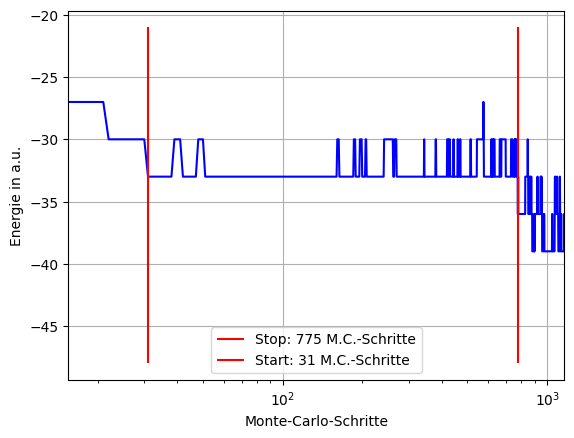

In [98]:
fig, ax = plt.subplots()

ax.set_xlabel('Monte-Carlo-Schritte')
ax.set_ylabel('Energie in a.u.')
ax.set_xscale('log')
plt.grid()

if stop != 0: 
    plt.xlim(0.5*start, 1.5*stop)
else:
    stop = steps
    plt.xlim(0.85*start, steps)
    
plt.xlim(0.5*start, 1.5*stop)
    
ax.plot(np.arange(steps), arr, color='blue')
ax.vlines(stop, min(arr), max(arr), colors='red', label='Stop: '+str(stop)+' M.C.-Schritte')
ax.vlines(start, min(arr), max(arr), colors='red', label='Start: '+str(start)+' M.C.-Schritte')

plt.legend(loc='lower center')

> Führe nun eine Mittelung über viele Simulationen in beiden Varianten von $J$ durch:

In [3]:
@njit(nogil=True)
def first_stable_average(protein_type, number_of_steps_each, number_of_samples, progress_proxy):
    starts = np.zeros(int(number_of_samples))
    for i in range(number_of_samples):
        p = network.create_protein(interaction_type=protein_type)
        _, start, _ = monte_carlo_find_first_stable(p, 1, number_of_steps_each, progress_proxy)
        starts[i] = start
    
    average = np.mean(starts)
    std = np.std(starts)

    return average, std   
    

In [5]:
samples = 1e6
steps = 1e3

with ProgressBar(total=2 * samples * steps) as progress:
    avg_const, std_const = first_stable_average('const', steps, samples, progress)
    avg_const_random_sign, std_const_random_sign = first_stable_average('const_random_sign', steps, samples, progress)
    
print('Konstantes Vorzeichen: ('+str(round(avg_const, 2))+' +/- '+str(round(std_const, 2))+') Monte-Carlo-Schritte')
print('Zufälliges Vorzeichen: ('+str(round(avg_const_random_sign, 2))+' +/- '+str(round(std_const_random_sign, 2))+') Monte-Carlo-Schritte')

  0%|          | 0/800000000.0 [00:00<?, ?it/s]

Konstantes Vorzeichen: (66.85 +/- 83.27) Monte-Carlo-Schritte
Zufälliges Vorzeichen: (58.53 +/- 81.72) Monte-Carlo-Schritte
